In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import random
import numpy as np

# 모델 재현을 위한 랜덤시드 고정
def set_random_seed(seed_value=42):
    # Python의 기본 난수 시드 설정
    random.seed(seed_value)
    # NumPy 난수 시드 설정
    np.random.seed(seed_value)
    # PyTorch 난수 시드 설정 (CPU)
    torch.manual_seed(seed_value)
    # PyTorch 난수 시드 설정 (GPU)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    # CuDNN 설정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

In [2]:
# GPU 사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def data_loading(data_dir, batch_size, train_transform, val_transform):
    """
    data_dir: 이미지 데이터셋 파일 경로
    batch_size: 배치 사이즈
    train_transform: 학습 데이터 변환기
    val_transform: 검증 데이터 변환기
    """
    # 데이터셋 경로
    train_path = os.path.join(data_dir, 'training_image')
    val_path = os.path.join(data_dir, 'validation_image')

    # 데이터셋 로드
    train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_path, transform=val_transform)

    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)

    return train_loader, val_loader

In [4]:
################################################################################
# Training
################################################################################
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange


def training(experiment_name, save_dir, data_loader, optimizer, criterion, scheduler=None):
    """
    experiment_name: 실험 이름
    save_dir: 모델 저장 경로
    data_loader: 데이터로더
    optimizer: 옵티마이저
    criterion: 손실 함수
    batch_size: 배치 사이즈
    scheduler: 스케줄러
    """

    train_loader, val_loader = data_loader

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, experiment_name), exist_ok=True)

    max_acc = 0

    train_loss_chart = []
    val_loss_chart = []

    train_acc_chart = []
    val_acc_chart = []

    for epoch in trange(NUM_EPOCHS):
        model.train()

        train_loss = 0
        train_correct = 0
        total = 0
        for images, labels in tqdm(train_loader, leave=False):
            images, labels = images.to(device), labels.to(device)
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True) # [4] 비동기 메모리 전송

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / total

        train_loss_chart.append(train_loss)
        train_acc_chart.append(train_acc)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")


        model.eval()
        val_loss = 0
        val_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, leave=False):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_acc = 100 * val_correct / total

        val_loss_chart.append(val_loss)
        val_acc_chart.append(val_acc)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # 가중치 스케줄러 업데이트
        if scheduler is not None:
            scheduler.step()

        # val_acc가 증가하면 모델 저장(최고 성능 모델 저장)
        if val_acc > max_acc:
            print(f"[INFO] val_acc has been improved from {max_acc:.5f} to {val_acc:.5f}. Saving Model!")
            max_acc = val_acc
            torch.save(model.state_dict(), f'{save_dir}/{experiment_name}/best_model.pth')

        # 모델 중간 저장
        if epoch+1 >= 20 and (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), f'{save_dir}/{experiment_name}/model_{epoch+1}.pth')
            print(f"Model saved at epoch -> {epoch+1}")


    # 학습 loss, acc 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_chart, label='Train Loss')
    plt.plot(val_loss_chart, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_chart, label='Train Accuracy')
    plt.plot(val_acc_chart, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()

    # 학습 시각화 저장
    plt.savefig(f'{save_dir}/{experiment_name}/train_val_loss.png')
    plt.show()

    # 모델 최종 저장
    torch.save(model.state_dict(), f'{save_dir}/{experiment_name}/model_final({epoch+1}).pth')
    print(f"Model saved at epoch {epoch+1}")

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [1/60], Train Loss: 3.3104, Train Acc: 7.67%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [1/60], Val Loss: 3.2819, Val Acc: 5.36%
[INFO] val_acc has been improved from 0.00000 to 5.36278. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [2/60], Train Loss: 3.1923, Train Acc: 9.19%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [2/60], Val Loss: 3.2918, Val Acc: 7.89%
[INFO] val_acc has been improved from 5.36278 to 7.88644. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [3/60], Train Loss: 3.1552, Train Acc: 9.88%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [3/60], Val Loss: 3.1520, Val Acc: 10.09%
[INFO] val_acc has been improved from 7.88644 to 10.09464. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [4/60], Train Loss: 3.1320, Train Acc: 9.90%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [4/60], Val Loss: 3.1728, Val Acc: 7.15%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [5/60], Train Loss: 3.1173, Train Acc: 10.00%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [5/60], Val Loss: 3.1684, Val Acc: 7.57%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [6/60], Train Loss: 3.0861, Train Acc: 10.98%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [6/60], Val Loss: 3.1200, Val Acc: 10.41%
[INFO] val_acc has been improved from 10.09464 to 10.41009. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [7/60], Train Loss: 3.0712, Train Acc: 10.84%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [7/60], Val Loss: 3.1345, Val Acc: 10.09%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [8/60], Train Loss: 3.0543, Train Acc: 10.69%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [8/60], Val Loss: 3.0958, Val Acc: 10.09%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [9/60], Train Loss: 3.0370, Train Acc: 11.50%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [9/60], Val Loss: 3.1056, Val Acc: 11.36%
[INFO] val_acc has been improved from 10.41009 to 11.35647. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [10/60], Train Loss: 3.0192, Train Acc: 12.29%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [10/60], Val Loss: 3.1486, Val Acc: 9.88%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [11/60], Train Loss: 3.0020, Train Acc: 11.65%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [11/60], Val Loss: 2.9937, Val Acc: 12.41%
[INFO] val_acc has been improved from 11.35647 to 12.40799. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [12/60], Train Loss: 2.9751, Train Acc: 13.64%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [12/60], Val Loss: 3.1309, Val Acc: 9.04%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [13/60], Train Loss: 2.9625, Train Acc: 13.19%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [13/60], Val Loss: 3.1296, Val Acc: 9.99%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [14/60], Train Loss: 2.9325, Train Acc: 13.46%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [14/60], Val Loss: 2.9315, Val Acc: 13.99%
[INFO] val_acc has been improved from 12.40799 to 13.98528. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [15/60], Train Loss: 2.9097, Train Acc: 14.18%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [15/60], Val Loss: 2.9137, Val Acc: 13.35%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [16/60], Train Loss: 2.9008, Train Acc: 14.50%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [16/60], Val Loss: 3.0960, Val Acc: 9.88%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [17/60], Train Loss: 2.8897, Train Acc: 14.15%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [17/60], Val Loss: 2.8985, Val Acc: 16.82%
[INFO] val_acc has been improved from 13.98528 to 16.82440. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [18/60], Train Loss: 2.8618, Train Acc: 15.50%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [18/60], Val Loss: 2.9059, Val Acc: 14.72%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [19/60], Train Loss: 2.8179, Train Acc: 17.00%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [19/60], Val Loss: 3.1728, Val Acc: 10.73%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [20/60], Train Loss: 2.7826, Train Acc: 17.54%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [20/60], Val Loss: 2.8773, Val Acc: 13.56%
Model saved at epoch -> 20


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [21/60], Train Loss: 2.6175, Train Acc: 21.79%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [21/60], Val Loss: 2.6440, Val Acc: 22.29%
[INFO] val_acc has been improved from 16.82440 to 22.29232. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [22/60], Train Loss: 2.5067, Train Acc: 24.23%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [22/60], Val Loss: 2.6095, Val Acc: 22.08%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [23/60], Train Loss: 2.4434, Train Acc: 25.58%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [23/60], Val Loss: 2.5652, Val Acc: 23.76%
[INFO] val_acc has been improved from 22.29232 to 23.76446. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [24/60], Train Loss: 2.3789, Train Acc: 26.73%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [24/60], Val Loss: 2.5487, Val Acc: 25.13%
[INFO] val_acc has been improved from 23.76446 to 25.13144. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [25/60], Train Loss: 2.3213, Train Acc: 29.21%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [25/60], Val Loss: 2.5044, Val Acc: 26.18%
[INFO] val_acc has been improved from 25.13144 to 26.18297. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [26/60], Train Loss: 2.2369, Train Acc: 31.13%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [26/60], Val Loss: 2.4490, Val Acc: 27.44%
[INFO] val_acc has been improved from 26.18297 to 27.44479. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [27/60], Train Loss: 2.1686, Train Acc: 34.00%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [27/60], Val Loss: 2.4613, Val Acc: 26.81%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [28/60], Train Loss: 2.0487, Train Acc: 38.26%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [28/60], Val Loss: 2.3911, Val Acc: 32.07%
[INFO] val_acc has been improved from 27.44479 to 32.07150. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [29/60], Train Loss: 1.9431, Train Acc: 41.08%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [29/60], Val Loss: 2.3092, Val Acc: 33.44%
[INFO] val_acc has been improved from 32.07150 to 33.43849. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [30/60], Train Loss: 1.8014, Train Acc: 46.76%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [30/60], Val Loss: 2.3158, Val Acc: 34.91%
[INFO] val_acc has been improved from 33.43849 to 34.91062. Saving Model!
Model saved at epoch -> 30


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [31/60], Train Loss: 1.6566, Train Acc: 52.63%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [31/60], Val Loss: 2.3118, Val Acc: 36.28%
[INFO] val_acc has been improved from 34.91062 to 36.27760. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [32/60], Train Loss: 1.5031, Train Acc: 58.53%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [32/60], Val Loss: 2.0949, Val Acc: 43.95%
[INFO] val_acc has been improved from 36.27760 to 43.95373. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [33/60], Train Loss: 1.3479, Train Acc: 63.61%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [33/60], Val Loss: 2.1568, Val Acc: 42.59%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [34/60], Train Loss: 1.1845, Train Acc: 69.83%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [34/60], Val Loss: 1.9484, Val Acc: 51.42%
[INFO] val_acc has been improved from 43.95373 to 51.41956. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [35/60], Train Loss: 0.9805, Train Acc: 77.99%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [35/60], Val Loss: 1.9334, Val Acc: 50.47%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [36/60], Train Loss: 0.8307, Train Acc: 82.80%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [36/60], Val Loss: 1.9011, Val Acc: 51.74%
[INFO] val_acc has been improved from 51.41956 to 51.73502. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [37/60], Train Loss: 0.6882, Train Acc: 87.25%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [37/60], Val Loss: 1.9863, Val Acc: 50.58%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [38/60], Train Loss: 0.5400, Train Acc: 90.79%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [38/60], Val Loss: 1.7925, Val Acc: 58.36%
[INFO] val_acc has been improved from 51.73502 to 58.35962. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [39/60], Train Loss: 0.4317, Train Acc: 93.66%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [39/60], Val Loss: 1.8500, Val Acc: 58.15%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [40/60], Train Loss: 0.3521, Train Acc: 95.41%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [40/60], Val Loss: 1.7311, Val Acc: 59.83%
[INFO] val_acc has been improved from 58.35962 to 59.83176. Saving Model!
Model saved at epoch -> 40


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [41/60], Train Loss: 0.2275, Train Acc: 98.18%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [41/60], Val Loss: 1.5996, Val Acc: 62.15%
[INFO] val_acc has been improved from 59.83176 to 62.14511. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [42/60], Train Loss: 0.1891, Train Acc: 98.85%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [42/60], Val Loss: 1.5807, Val Acc: 61.93%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [43/60], Train Loss: 0.1730, Train Acc: 99.04%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [43/60], Val Loss: 1.5790, Val Acc: 62.46%
[INFO] val_acc has been improved from 62.14511 to 62.46057. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [44/60], Train Loss: 0.1593, Train Acc: 99.29%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [44/60], Val Loss: 1.5655, Val Acc: 62.15%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [45/60], Train Loss: 0.1450, Train Acc: 99.46%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [45/60], Val Loss: 1.5602, Val Acc: 62.36%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [46/60], Train Loss: 0.1399, Train Acc: 99.53%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [46/60], Val Loss: 1.5660, Val Acc: 62.57%
[INFO] val_acc has been improved from 62.46057 to 62.56572. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [47/60], Train Loss: 0.1321, Train Acc: 99.56%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [47/60], Val Loss: 1.5647, Val Acc: 62.25%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [48/60], Train Loss: 0.1218, Train Acc: 99.63%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [48/60], Val Loss: 1.5526, Val Acc: 62.57%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [49/60], Train Loss: 0.1208, Train Acc: 99.73%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [49/60], Val Loss: 1.5514, Val Acc: 63.20%
[INFO] val_acc has been improved from 62.56572 to 63.19664. Saving Model!


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [50/60], Train Loss: 0.1125, Train Acc: 99.58%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [50/60], Val Loss: 1.5511, Val Acc: 63.09%
Model saved at epoch -> 50


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [51/60], Train Loss: 0.1065, Train Acc: 99.73%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [51/60], Val Loss: 1.5508, Val Acc: 62.99%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [52/60], Train Loss: 0.1000, Train Acc: 99.80%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [52/60], Val Loss: 1.5489, Val Acc: 62.67%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [53/60], Train Loss: 0.0980, Train Acc: 99.80%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [53/60], Val Loss: 1.5491, Val Acc: 62.99%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [54/60], Train Loss: 0.0939, Train Acc: 99.75%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [54/60], Val Loss: 1.5475, Val Acc: 62.36%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [55/60], Train Loss: 0.0888, Train Acc: 99.80%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [55/60], Val Loss: 1.5405, Val Acc: 62.36%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [56/60], Train Loss: 0.0860, Train Acc: 99.83%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [56/60], Val Loss: 1.5418, Val Acc: 62.46%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [57/60], Train Loss: 0.0818, Train Acc: 99.75%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [57/60], Val Loss: 1.5450, Val Acc: 62.67%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [58/60], Train Loss: 0.0769, Train Acc: 99.80%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [58/60], Val Loss: 1.5492, Val Acc: 62.99%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [59/60], Train Loss: 0.0770, Train Acc: 99.75%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [59/60], Val Loss: 1.5479, Val Acc: 62.57%


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch [60/60], Train Loss: 0.0736, Train Acc: 99.78%


  0%|          | 0/951 [00:00<?, ?it/s]

Epoch [60/60], Val Loss: 1.5481, Val Acc: 63.09%
Model saved at epoch -> 60


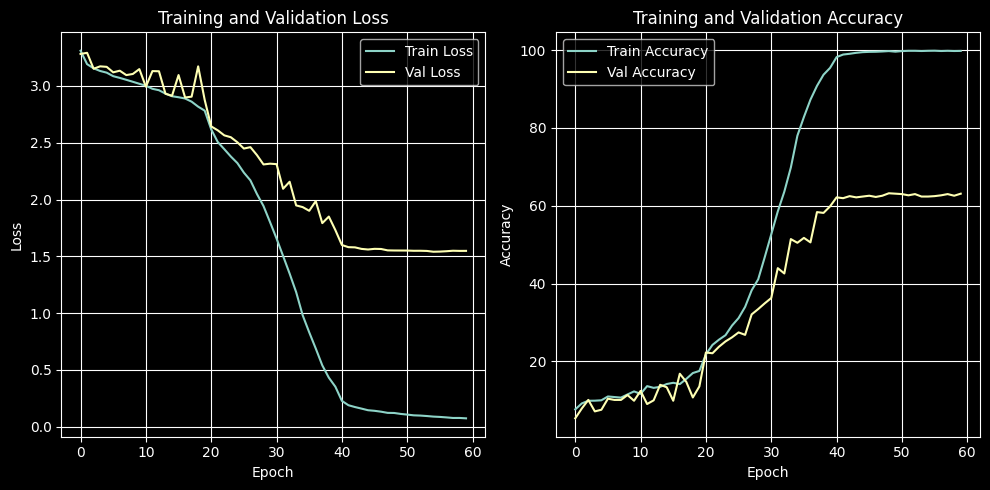

Model saved at epoch 60


In [5]:
# 파라미터 설정
LR = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 60
WEIGHT_DECAY = 5e-4

# 실험 이름, 저장 경로 설정
EXP_NAME = 'exp4'
SAVE_DIR = "./baseline_4"

# 데이터 전처리
t_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # ImageNet 정규화
])
v_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # ImageNet 정규화
])

data_loader = data_loading(
    data_dir='../categorized_data',
    batch_size=BATCH_SIZE,
    train_transform=t_transform,
    val_transform=v_transform
)

# ResNet18 모델 불러오기(가중치 X)
model = models.resnet18(weights=None, num_classes=31)
model = model.to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)


training(
    experiment_name=EXP_NAME,
    save_dir=SAVE_DIR,
    data_loader=data_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler
)

In [7]:
# best model 성능 확인
best_path = f"{SAVE_DIR}/{EXP_NAME}/best_model.pth"
model.load_state_dict(torch.load(best_path, weights_only=True))

def evaluate_model(model, data_loader):
    model.eval()
    val_loss = 0
    val_correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss /= len(data_loader)
        val_acc = 100 * val_correct / total

    print(f"Best Model Performance | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return np.array(all_preds), np.array(all_labels), val_loss, val_acc


y_pred, y_true, val_loss, val_acc = evaluate_model(model, data_loader[1])

  0%|          | 0/951 [00:00<?, ?it/s]

Best Model Performance | Val Loss: 1.5514, Val Acc: 63.20%


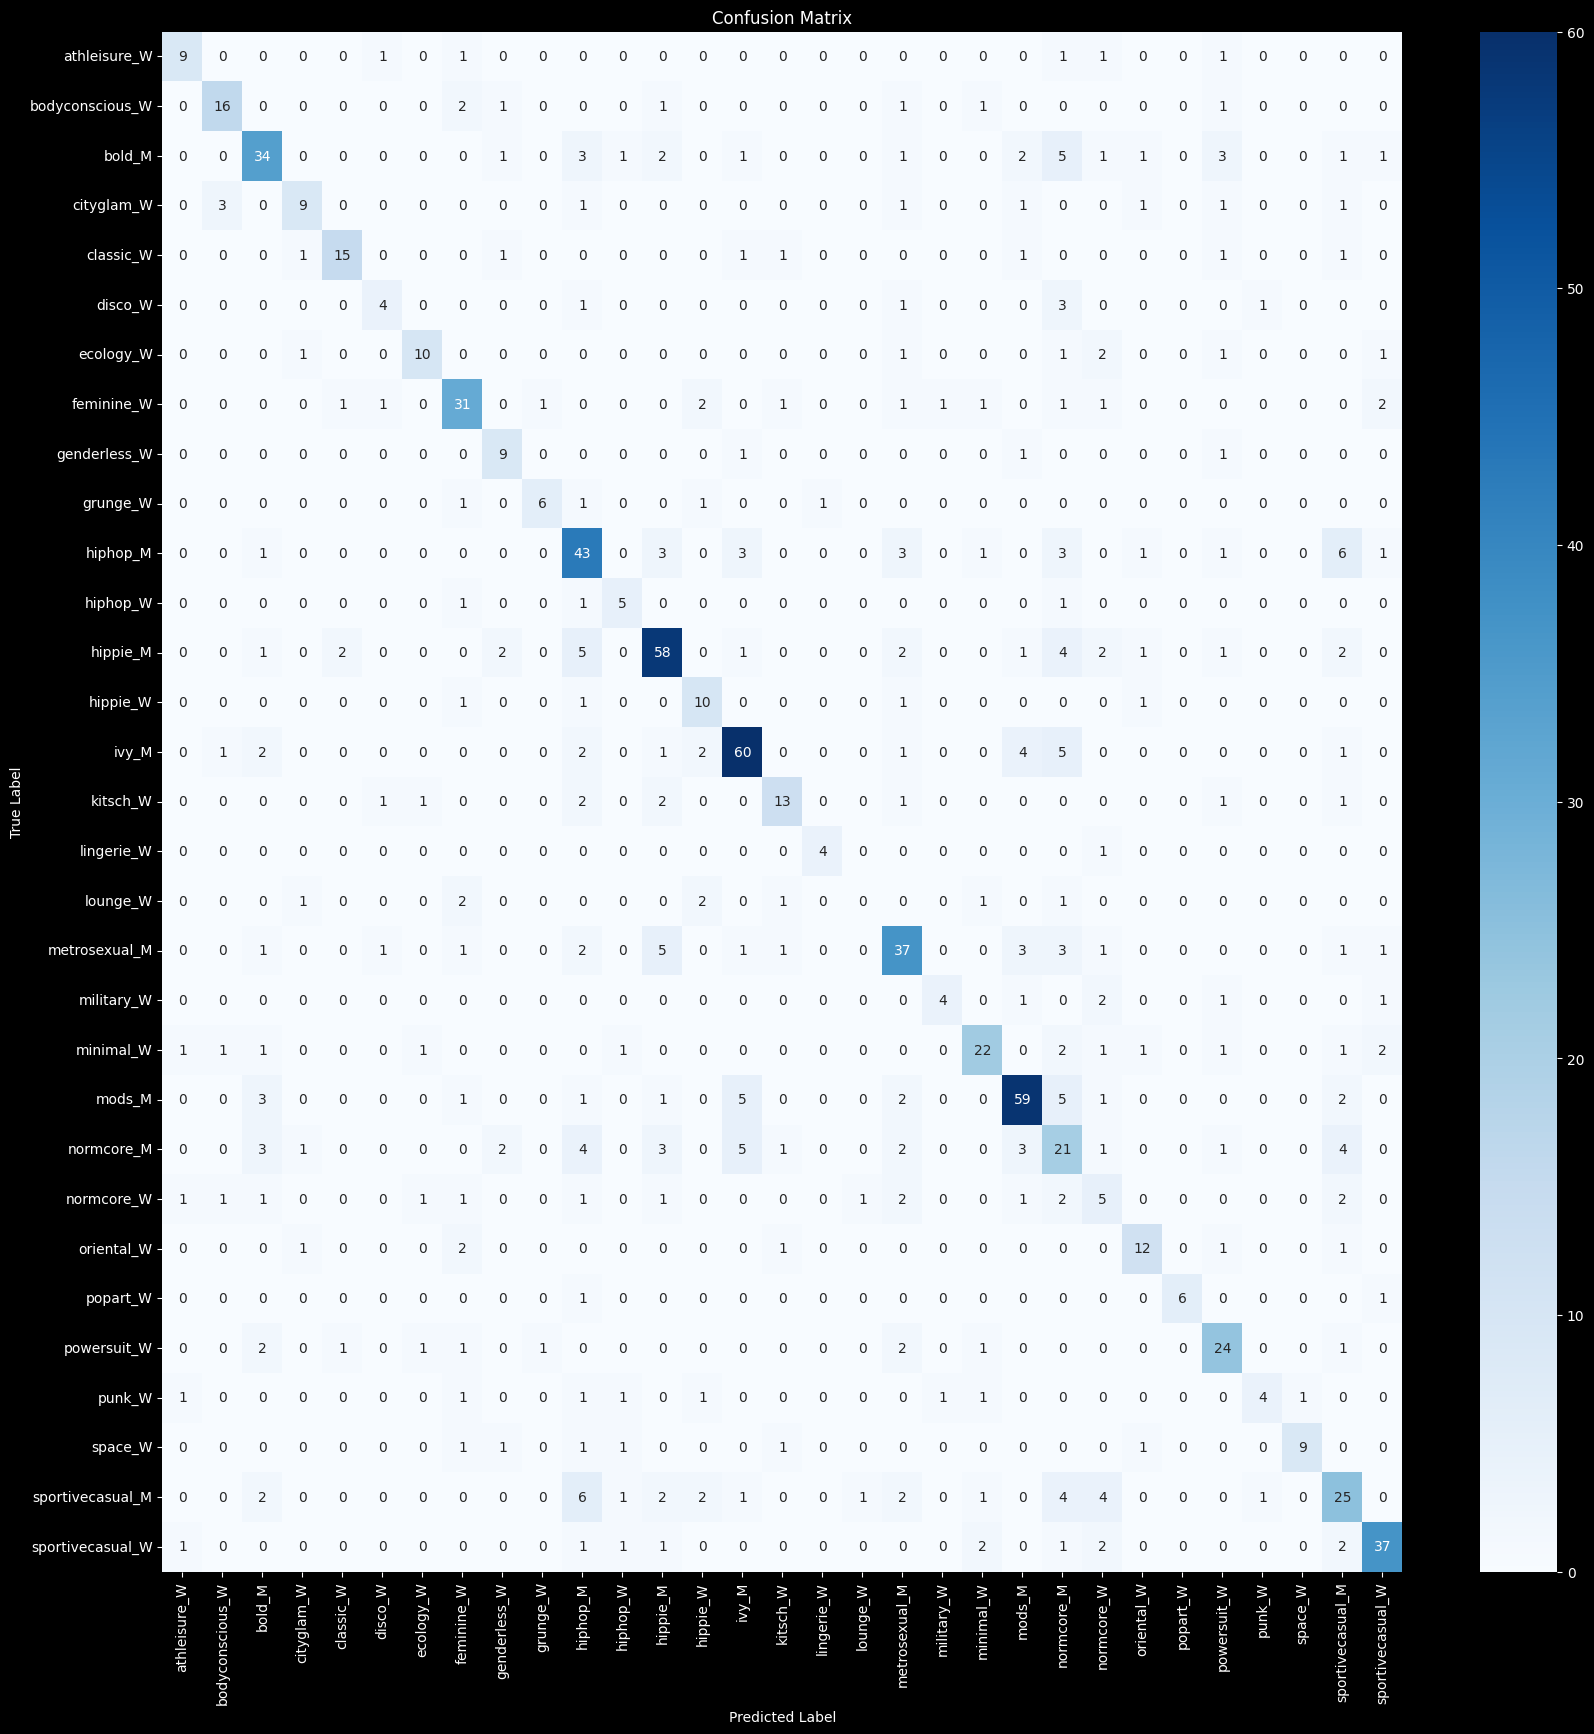

                  precision    recall  f1-score   support

    athleisure_W      0.692     0.643     0.667        14
 bodyconscious_W      0.727     0.696     0.711        23
          bold_M      0.667     0.596     0.630        57
      cityglam_W      0.643     0.500     0.563        18
       classic_W      0.789     0.682     0.732        22
         disco_W      0.500     0.400     0.444        10
       ecology_W      0.714     0.588     0.645        17
      feminine_W      0.660     0.705     0.681        44
    genderless_W      0.529     0.750     0.621        12
        grunge_W      0.750     0.600     0.667        10
        hiphop_M      0.551     0.652     0.597        66
        hiphop_W      0.455     0.625     0.526         8
        hippie_M      0.725     0.707     0.716        82
        hippie_W      0.500     0.714     0.588        14
           ivy_M      0.759     0.759     0.759        79
        kitsch_W      0.650     0.591     0.619        22
      lingeri

In [9]:
# 어떤 class를 분류 못 하는지 확인
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def print_classification_report(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, digits=3)
    print(report)

# 클래스 이름 리스트
train_dataset = datasets.ImageFolder('../categorized_data/training_image')
class_names = train_dataset.classes

# 혼동 행렬 플롯
plot_confusion_matrix(y_true, y_pred, class_names)

# 분류 보고서 출력
print_classification_report(y_true, y_pred, class_names)

In [10]:
# 가장 성능이 낮은 클래스 10개 출력
class_accuracy = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
class_accuracy = {k: v['f1-score'] for k, v in class_accuracy.items() if k in class_names}
worst_classes = sorted(class_accuracy.items(), key=lambda x: x[1])[:10]

print("Worst performing classes:")
for cls, score in worst_classes:
    print(f"{cls}: {score:.3f}")

Worst performing classes:
lounge_W: 0.000
normcore_W: 0.222
normcore_M: 0.368
punk_W: 0.444
disco_W: 0.444
sportivecasual_M: 0.481
hiphop_W: 0.526
military_W: 0.533
cityglam_W: 0.563
hippie_W: 0.588
